In [1]:
import math
import functools
import numpy as np
import scipy as sci
import matplotlib.pyplot as plt
import qutip as qt
import time

In [2]:
# This dictionary maps string keys ('x', 'y', 'z', 'p', 'm', 'i') to functions that generate spin operators for a given dimension dim.
opstr2fun = {'x': lambda dim: qt.spin_Jx((dim-1)/2),
             'y': lambda dim: qt.spin_Jy((dim-1)/2),
             'z': lambda dim: qt.spin_Jz((dim-1)/2),
             'p': lambda dim: qt.spin_Jp((dim-1)/2),
             'm': lambda dim: qt.spin_Jm((dim-1)/2),
             'i': qt.identity}
# Initializes ops as a list of identity matrices for each dimension in dims. Iterates over specs to replace the identity matrix at the specified index with the corresponding spin operator. Returns the tensor product of the operators in ops using qt.tensor.
def mkSpinOp(dims, specs):
    ops = [qt.identity(d) for d in dims]
    for ind, opstr in specs:
        ops[ind] = ops[ind] * opstr2fun[opstr](dims[ind])
    return qt.tensor(ops)
# Constructs a Hamiltonian for a single spin system with interactions along the x, y, and z axes.
def mkH1(dims, ind, parvec):
    axes = ['x', 'y', 'z']
    # Creates a list of spin operators weighted by the corresponding parameters in parvec (ignores zero parameters). Uses functools.reduce to sum these weighted spin operators.
    return functools.reduce(lambda a, b: a + b, 
               [v * mkSpinOp(dims, [(ind,ax)]) for v, ax in zip(parvec, axes) if v!=0])
# Constructs a Hamiltonian for the interaction between two spin systems with interaction terms along all combinations of x, y, and z axes.
def mkH12(dims, ind1, ind2, parmat):
    axes = ['x', 'y', 'z']
    ops = []
    # Iterates over all combinations of the x, y, and z axes for the two spins. For each non-zero element in parmat, adds the corresponding spin-spin interaction term to the empty list ops.
    for i in range(3):
        for j in range(3):
            if parmat[i,j] != 0:
                ops.append(parmat[i,j] * mkSpinOp(dims, [(ind1,axes[i]), (ind2,axes[j])]))
    return functools.reduce(lambda a, b: a + b, ops) # Uses functools.reduce to sum these interaction terms.

In [20]:
b0 = 1.4 * 2*math.pi # Zeeman field strength in radians per microsecond
A = np.diag([-2.6, -2.6, 49.2]) * 2*math.pi # Hyperfine coupling matrix (Mrad/s)
kr = 1. # Rate constant 1/us
tmax = 12. / kr # Maximum time us
tlist = np.linspace(0, tmax, math.ceil(1000*tmax)) # Time points for simulation
B0 = b0 * np.array([1,0,0]) # Magnetic field vector along x-axis

dims = [2, 2, 3] # Dimensions of the system components (2 qubits, 1 spin-1 nucleus)
dim = np.prod(dims) # Total dimension of the composite system
Hzee = mkH1(dims, 0, B0) + mkH1(dims, 1, B0) # Zeeman Hamiltonian for two spins
Hhfc = mkH12(dims, 0, 2, A) # Hyperfine coupling Hamiltonian
H0 = Hzee + Hhfc # Total Hamiltonian

Ps = 1/4 * mkSpinOp(dims,[]) - mkH12(dims, 0, 1, np.identity(3)) # Singlet projection operator

rho0 = (Ps / Ps.tr()).full().flatten() # Initial density matrix, normalized projection operator for the singlet state.
H =H0.data # H: Dense matrix representation of the Hamiltonian H0.
Ps = Ps.data
print(len(rho))

144


In [7]:
from scipy.integrate import ode

In [8]:
def mesolve(t, rho, Hamiltonian):
    # Reshape rho back to a matrix
    dim = int(np.sqrt(len(rho)))
    rho = rho.reshape((dim, dim))
    
    # Compute the derivative of rho
    drho_dt = -1j * (Hamiltonian @ rho - rho @ Hamiltonian)
    
    # Flatten the derivative to a vector
    return drho_dt.flatten()

In [18]:
#roughly what mesolve uses internally 
solver = ode(mesolve).set_integrator('zvode', atol=1e-8, rtol=1e-6, method='adams', order=12)
solver.set_initial_value(rho0, 0).set_f_params(H)

t = [(0.,1)]
dt = 0.001

start = time.time()
while solver.successful() and solver.t < tmax:
    rho = solver.integrate(solver.t + dt)
    dim = int(np.sqrt(len(rho)))
    rho = rho.reshape((dim, dim))
    t.append((solver.t, np.trace(Ps @ rho)))
    
stop = time.time()

print("{} sec".format(stop - start))

tlist = np.array([x for x,y in t])
ps = np.array([np.real(y) for x,y in t]) 
yr = kr * sci.integrate.simps(ps * np.exp(-kr*tlist), tlist)
print(yr)

1.2304620742797852 sec
0.49820889024745796


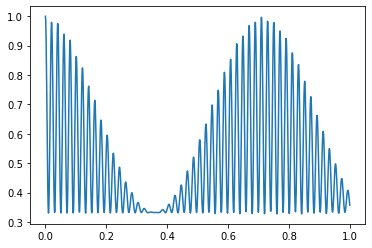

In [19]:
plt.plot(tlist[:1000], ps[:1000])